In [10]:
import sys
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
import time
from IPython.core.display import display, HTML                                # Make the Cell width of the notebook wider
display(HTML("<style>.container { width:80% !important; }</style>"))        

In [2]:
#-----------------------------------------------------------------------------------------------------------------------------------------
# Title: Solving the ODE for eta and phi
#-----------------------------------------------------------------------------------------------------------------------------------------
# Contents: 
#-----------------------------------------------------------------------------------------------------------------------------------------

# Section 1.0:   Define a function that will integrate through the domain and return phi_{n+1} 

# Section 2.0:   Define a function that will calculate R and S in d2phi/dy2 + R(y) dphi/dy + S(y) phi = 0
# Section 2.1:   Allocate memory to the variables and define the constants in the ODE
# Section 2.2:   Calculate R and S in the ODE for each profile

# Section 3.0:   Define an ODE solver that will use the previous functions to solve the ODE
# Section 3.1:   Define constants and set up the grid in y
# Section 3.2:   Set up the values for the wave speed and wave number that we will loop over 
# Section 3.3:   Print the user defined options
# Section 3.4:   Find R and S for c_0 (first choice of wave speed) and then integrate to find phi with boundary conditions
# Section 3.4.1: Begin the iteration towards a solution for wavenumber in the outer loop 
# Section 3.4.2: Solving for the first choice of wave speed 
# Section 3.5:   Print outputs for functions evaluated over y and at (k,c_0)
# Section 3.6:   Iterate towards a solution for the ODE over all the wave speed increments
# Section 3.7:   Print outputs for functions evaluated over y and at (k,c_1)
# Section 3.8:   Print output for functions at each step evaluated over y
# Section 3.9:   Shooting method to find c
# Section 3.10:  Plots for fixing k and varying c_{i}
# Section 3.11:  Plots for fixing c_{i} and varying k
# Section 3.12:  Fix k and vary c_{i} for abs(PHI)
# Section 3.13:  Fix c_{i} and vary k for abs(PHI)
# Section 3.14:  Update the wavenumber in preperation for the next loop

# Section 4.0:   Set up for plots
# Section 4.1:   Plots of the profiles and coefficients of the ODEs
# Section 4.2:   Plot of the growth rate
# Section 4.3:   Plot the levels where the ODEs are singular

# Section 5.0:   Time taken for the code to run

In [3]:
#-----------------------------------------------------------------------------------------------------------------------------------------
# Section 1.0 : Define a function that will integrate through the domain and return phi_{n+1}  
#-----------------------------------------------------------------------------------------------------------------------------------------
def INT_REES(phi_nm1 , phi_n,  R_n , S_n , y_nm1 , y_n , y_np1):      
    import sys
    import numpy as np
    import math
    import cmath
    import matplotlib.pyplot as plt

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# phi_nm1 = phi_{n-1} , phi_n = phi_{n} , R_n = R_{n} , S_n = S_{n} , y_nm1 = y_{n-1} , y_n = y_{n} , y_np1 = y_{n+1}
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Finite Difference Scheme

# It is assumed that the grid spacing is uniform

# Using a centered finite difference scheme 
# phi = phi_n                                                          
# d/dy phi = (phi_np1-phi_nm1) / 2(y_np1-y_n)                                
# d^{2}/dy^{2} phi = (phi_np1-2*phi_n+phi_nm1) / (y_np1-y_n)^{2}

# phi_np1 [ 1.0/(y_np1 - y_n)^2 + P_n/(y_np1 - y_nm1) ] +  [ (- 2 phi_n + phi_nm1 )/(y_np1 - y_n)^2  -  P_n phi_nm1/(y_np1 - y_nm1) + Q_n phi_n ] = 0

    dy      = y_np1 - y_n 
    denom   = 1.0 / (dy*dy) + (R_n/(y_np1 - y_nm1))               
    num2    =  S_n * phi_n - (R_n * phi_nm1 / (y_np1 - y_nm1))
    num1    =  (-2.0 * phi_n + phi_nm1) / (dy*dy) 
    phi_np1 = - (num1 + num2) / denom

    return phi_np1

In [4]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Section 2.0 : Define a function that will calculate R and S in d2phi/dy2 + R(y) dphi/dy + S(y) phi = 0
#------------------------------------------------------------------------------------------------------------------------------------------

# Calculating R and S
def R_S_Rees(y, c_n , k):   # y is an array of np.zeros, and k is the wavenumber
    import sys
    import numpy as np
    import math
    import cmath
    import matplotlib.pyplot as plt

#-----------------------------------------------------------------------------------------------------------------------------------------
# Section 2.1 : Allocate memory to the variables and define the constants in the ODE
#------------------------------------------------------------------------------------------------------------------------------------------
  
    len_y = len(y)  # y=np.zeros( no. of levels + 2 , dtype =np.complex ) , see section 3.1
  
    # Allocate memory for the numpy arrays   
    R      = np.zeros( len_y, dtype =  np.complex )     
    S      = np.zeros( len_y, dtype =  np.complex )
    Rv     = np.zeros( len_y, dtype =  np.complex )
    Sv     = np.zeros( len_y, dtype =  np.complex )
    Rs     = np.zeros( len_y, dtype =  np.complex )
    Ss     = np.zeros( len_y, dtype =  np.complex )
    f      = np.zeros( len_y, dtype =  np.complex )
    B      = np.zeros( len_y, dtype =  np.complex )
    H      = np.zeros( len_y, dtype =  np.complex )
    dHdy   = np.zeros( len_y, dtype =  np.complex )
    U      = np.zeros( len_y, dtype =  np.complex )
    dUdy   = np.zeros( len_y, dtype =  np.complex )
    HQ     = np.zeros( len_y, dtype =  np.complex )
    dHQdy  = np.zeros( len_y, dtype =  np.complex )
    D      = np.zeros( len_y, dtype =  np.complex )
    dDdy   = np.zeros( len_y, dtype =  np.complex )
    F      = np.zeros( len_y, dtype =  np.complex )
    dFdy   = np.zeros( len_y, dtype =  np.complex )
    G      = np.zeros( len_y, dtype =  np.complex )
    dGdy   = np.zeros( len_y, dtype =  np.complex )
    d2Udy2 = np.zeros( len_y, dtype =  np.complex )

    # Define the constants
    beta   = 2.2*(10**-11)       
    g      = 0.0334              # Reduced gravity
    H0     = 140                  # Average thermocline depth (see Tanaka+Hibiya)
    A      = [-0.5,-0.5,-5,-0.5]
    c      = np.sqrt(g*H0)      
    C      = np.sqrt((2*beta/c))  
    #y     = C*x                 # Non-dimensional y
    i      = 5                   # Choose your profile: i = [0 (n=0), 1 (n=2), 2 (Cubic), 3 (Quintic) , 4 (Sinusoidal), 5(Cosine)]
    L      = 10

#--------------------------------------------------------------------------------------------------------------------------------------------
# Section 2.2 : Calculate R and S in the ODE for each profile
#--------------------------------------------------------------------------------------------------------------------------------------------
    for iy in range ( len_y ) :
        if i == 0:
            f[iy]     = beta*y[iy]           
            B[iy]     = (y[iy]**2)/4.0  
            H[iy]     = A[0] * np.exp(-B[iy])                                                     
            dHdy[iy]  = - (A[0] / 2.0) * C * y[iy] * np.exp(-B[iy])                               
            U[iy]     = (g * A[0] / c) * np.exp(-B[iy])                                           
            dUdy[iy]  = -(g * A[0] / (2*c))*C*y[iy]*np.exp(-B[iy])
            HQ[iy]    = beta * (1 / C) * y[iy] + (g * A[0] / 2 * c) * C * y[iy] * np.exp(-B[iy])  
            dHQdy[iy] = beta - (g*A[0]/4*c)*(C**3)*((y[iy]**2)-2)*np.exp(-B[iy])
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))                                                         
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))        
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            R[iy]     = (-1.0 / F[iy])*dFdy[iy]
            S[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Rv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Sv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            Rs[iy]    = 0
            Ss[iy]    = (dHQdy[iy])/(U[iy]-c_n) -(k**2)
            
        if i == 1:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/(4.0)
            H[iy]     = A[2]*((y[iy]**2)-1)*np.exp(-B[iy])
            dHdy[iy]  = -(A[2]/2.0)*C*y[iy]*((y[iy]**2)-5)*np.exp(-B[iy])
            U[iy]     = -(g*A[2]/c)*((y[iy]**2)-5)*np.exp(-B[iy])
            dUdy[iy]  = (g*A[2]/(2*c))*C*y[iy]*np.exp(-B[iy])*((y[iy]**2)-9) 
            HQ[iy]    = beta*(1/C)*y[iy] + (g*A[2]/(2*c))*C*y[iy]*np.exp(-B[iy])*((y[iy]**2)+9) 
            dHQdy[iy] = beta + (g*A[2]/2*c)*C*(2*C*(y[iy]**2)*np.exp(-B[iy])+((y[iy]**2)+9)*(-0.5*C*((y[iy]**2)-2)*np.exp(-B[iy])))
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))  
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            R[iy]     = (-1.0 / F[iy])*dFdy[iy]
            S[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Rv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Sv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            Rs[iy]    = 0
            Ss[iy]    = (dHQdy[iy])/(U[iy]-c_n) -(k**2)
            
        if i == 2:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            H[iy]     = (y[iy]**3)*np.exp(-B[iy])
            dHdy[iy]  = 3*(y[iy]**2)*C*np.exp(-B[iy])-0.5*C*(y[iy]**4)*np.exp(-B[iy])
            U[iy]     = (g/c)*y[iy]*np.exp(-B[iy])*((y[iy]**2)-6)
            dUdy[iy]  =  (g/c)*(-0.5*C*((y[iy]**2)-2)*((y[iy]**2)-6)*np.exp(-B[iy])+2*C*(y[iy]**2)*np.exp(-B[iy]))
            HQ[iy]    = beta*(1/C)*y[iy] - (g/c)*(-0.5*C*((y[iy]**2)-2)*((y[iy]**2)-6)*np.exp(-B[iy])+2*C*(y[iy]**2)*np.exp(-B[iy]))
            dHQdy[iy] = beta - (g/c)*C*((-0.5*C*y[iy]*np.exp(-B[iy]))*(-0.5*((y[iy]**2) -2)*((y[iy]**2) -6)+2*(y[iy]**2)) + np.exp(-B[iy])*(-2*C*(y[iy]**3)+12*y[iy]*C))
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))  
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))  
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            R[iy]     = (-1.0 / F[iy])*dFdy[iy]
            S[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Rv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Sv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            Rs[iy]    = 0
            Ss[iy]    = (dHQdy[iy])/(U[iy]-c_n) -(k**2)
            
        if i == 3:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/4.0
            H[iy]     = (y[iy]**5)*np.exp(-B[iy])
            dHdy[iy]  = -0.5*C*(y[iy]**4)*np.exp(-B[iy])*((y[iy]**2)-10)
            U[iy]     = (g/c)*(y[iy]**3)*np.exp(-B[iy])*((y[iy]**2)-10)
            dUdy[iy]  = (g/c)*(-(1/2)*C*((y[iy]**2))*((y[iy]**2)-6)*((y[iy]**2)-10)*np.exp(-B[iy])+2*C*(y[iy]**4)*np.exp(-B[iy]))
            HQ[iy]    = beta*(1/C)*y[iy] - (g/c)*(-(1/2)*C*((y[iy]**2))*((y[iy]**2)-6)*((y[iy]**2)-10)*np.exp(-B[iy])+2*C*(y[iy]**4)*np.exp(-B[iy]))
            dHQdy[iy] = beta - (g/c)*C*(-0.5*C*y[iy]*np.exp(-B[iy])*(-0.5*(y[iy]**2)*((y[iy]**2) -6)*((y[iy]**2) -10)+2*(y[iy]**4))+np.exp(-B[iy])*(6*C*(y[iy]**5)-56*C*(y[iy]**3)+120*C*y[iy]))
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            R[iy]     = (-1.0 / F[iy])*dFdy[iy]
            S[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Rv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Sv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            Rs[iy]    = 0
            Ss[iy]    = (dHQdy[iy])/(U[iy]-c_n) -(k**2)
            
        if i == 4:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/(4.0)
            m         = 1
            U[iy]     = A[0]*np.sin(m*np.pi*y[iy] / (C*L))   
            H[iy]     = -(A[0]*(beta) / g)*((L/m*np.pi)**2)*((np.sin(m*np.pi*y[iy]/(C*L))-(L/(m*np.pi*C))*y[iy]*np.cos(m*np.pi*y[iy]/(C*L))))
            dUdy[iy]  = A[0]*(m*np.pi/L)*np.cos(m*np.pi*y[iy]/(C*L))
            dHdy[iy]  = -(beta/(C*g))*y[iy]*A[0]*np.sin(m*np.pi*y[iy]/(C*L))
            HQ[iy]    = (beta/C)*y[iy] - A[0]*(m*np.pi/L)*np.cos(m*np.pi*y[iy]/(C*L))
            dHQdy[iy] =  beta + A[0]*((m*np.pi/L)**2)*np.sin(m*np.pi*y[iy]/(C*L)) 
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            R[iy]     = (-1.0 / F[iy])*dFdy[iy]
            S[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Rv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Sv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v 
            Rs[iy]    = 0
            Ss[iy]    = (dHQdy[iy])/(U[iy]-c_n) -(k**2)
            
        if i == 5:
            f[iy]     = beta*y[iy]
            B[iy]     = (y[iy]**2)/(4.0)
            m         = 1
            U[iy]     = A[0]*np.cos(m*np.pi*y[iy]/(L))   
            H[iy]     = -(A[0]*(beta) / g)*((L/m*np.pi)**2)*((np.cos(m*np.pi*y[iy]/(L))+(L/(m*np.pi))*y[iy]*np.sin(m*np.pi*y[iy]/(L))))
            dUdy[iy]  = -A[0]*(m*np.pi/L)*np.sin(m*np.pi*y[iy]/(L))
            dHdy[iy]  = -(beta/(g))*y[iy]*A[0]*np.cos(m*np.pi*y[iy]/(L))
            HQ[iy]    = (beta)*y[iy] + A[0]*(m*np.pi/L)*np.sin(m*np.pi*y[iy]/(L))
            dHQdy[iy] =  beta + A[0]*((m*np.pi/L)**2)*np.cos(m*np.pi*y[iy]/(L)) 
            D[iy]     = (k**2) * ((U[iy] - c_n)**2) - f[iy] * HQ[iy]
            dDdy[iy]  = 2 * (k**2) * dUdy[iy] * (U[iy] - c_n) - beta * HQ[iy] - f[iy] * dHQdy[iy] 
            F[iy]     = D[iy] / (g*(H0+H[iy]))
            dFdy[iy]  = dDdy[iy] / (g*(H0+H[iy])) - (D[iy]*dHdy[iy]) / (g*((H0+H[iy])**2))
            G[iy]     = (k**2)*((U[iy]-c_n)**2 - g*(H0+H[iy]))                                    # ODE for v
            dGdy[iy]  = (k**2)*(2*dUdy[iy]*(U[iy]-c_n) - g*dHdy[iy])                              # ODE for v
            R[iy]     = (-1.0 / F[iy])*dFdy[iy]
            S[iy]     = ((F[iy] - (k**2)) + ((f[iy] * dFdy[iy] / F[iy]) - beta) / (U[iy] - c_n))
            Rv[iy]    = (-dGdy[iy]/(G[iy]*(U[iy]-c_n)))                                           # ODE for v
            Sv[iy]    = (F[iy]-(k**2))-(dHQdy[iy] - (HQ[iy]/G[iy])*dGdy[iy])/(U[iy]-c_n)          # ODE for v
            Rs[iy]    = 0
            Ss[iy]    = (dHQdy[iy])/(U[iy]-c_n) -(k**2)
        
 
    return R, S, U, H, dUdy, dHdy, HQ, dHQdy, D ,dDdy, F, dFdy, G, dGdy, f, Rv, Sv, Rs, Ss

0
k = 0.010000000000001, c = (0.49256739311450826+0.011822646467804189j)
1
k = 0.020000000000001, c = (0.47964207754245186+0.030109493437273562j)
2
k = 0.030000000000000998, c = (0.4634565900942933+0.049299006013085664j)
3
k = 0.040000000000001, c = (0.44450658116619357+0.06794038238436852j)
4
k = 0.050000000000001, c = (0.4233130800673572+0.08508853227781962j)
5
k = 0.060000000000001004, c = (0.400422923100237+0.10013923762891185j)
6
k = 0.070000000000001, c = (0.3763816233653228+0.11274192562787845j)
7
k = 0.080000000000001, c = (0.35170154159215095+0.12274101304099434j)
8
k = 0.090000000000001, c = (0.326836791488987+0.13012758163181853j)
9
k = 0.10000000000000099, c = (0.3021681907667574+0.1349972206393946j)
10
k = 0.11000000000000099, c = (0.2779977752008563+0.13751397687434894j)
11
k = 0.12000000000000098, c = (0.2545507677237936+0.137880964204931j)
12
k = 0.13000000000000098, c = (0.2319824636407676+0.13631773040708725j)
13
k = 0.14000000000000098, c = (0.21038772604092823+0.133

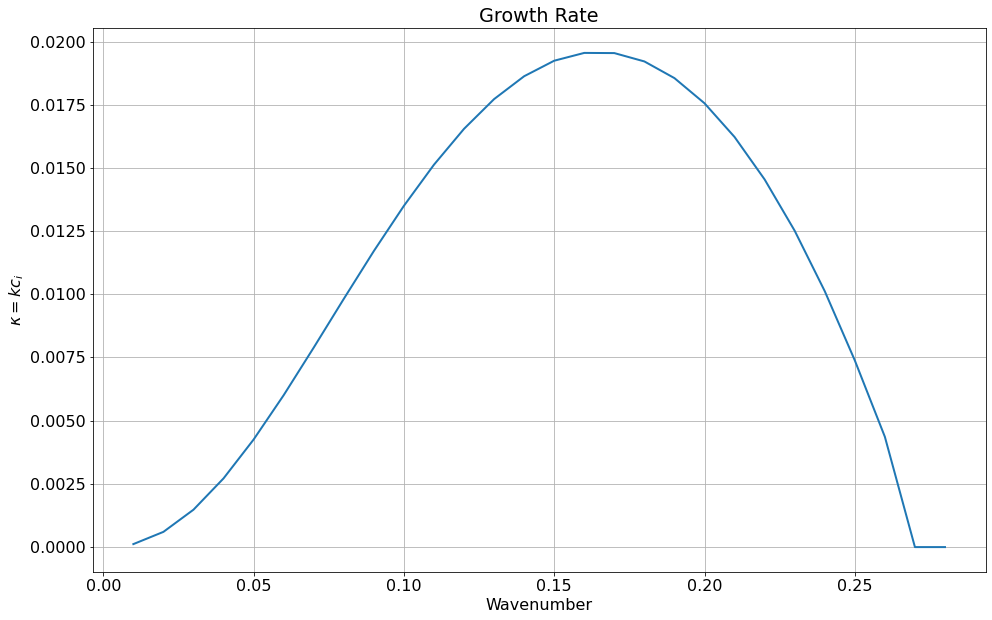

In [5]:
#-----------------------------------------------------------------------------------------------------------------------------------------
# Section 3.0 : Define an ODE solver that will use the previous functions to solve the ODE
#------------------------------------------------------------------------------------------------------------------------------------------
def ODE_SOLVER_REES():
    import sys
    import math
    import cmath
    import numpy as np
    import matplotlib.pyplot as plt
    import time
    
    start_time=time.time()
#-------------------------------------------------------------------------------------------------------------------------------------------
# Section 3.1 : Define constants and set up the grid in y
#-------------------------------------------------------------------------------------------------------------------------------------------
    Levels      = 100                 # Number of levels
    Tolerance   = 1e-7                # Tolerance for errors (see Section 3.9)
    beta        = 2.2*(10**-11)       
    g           = 0.0334              # Reduced gravity
    H0          = 60                  # Average thermocline depth (see Tanaka + Hibiya 2019)
    c           = np.sqrt(g*H0) 
    C           = np.sqrt((2*beta/c)) 
   
    SMALL_SIZE  = 14                # Set the sizes for the text in plots
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 22

    y  = np.zeros(Levels + 2)       # Allocate memory to y
    dy = 1.0 / float(Levels)        # float/float = float
    L = 10                          # Length of half the domain
    M = 2*L                         
    for n in range(Levels + 2):
        y[n] = -L + M * n * dy  
    
#--------------------------------------------------------------------------------------------------------------------------------------------
# Section 3.2 : Set up the values for the wave speed and wavenumber that we will loop over 
#--------------------------------------------------------------------------------------------------------------------------------------------
    start       = -1
    end         = 1
    step        = 1
    ws_start    = np.linspace(start,end,step)
    cs_converge = np.zeros(len(ws_start),dtype=np.complex)
    for iteration in range(step):

        wavespeedre = [0.49]  # ws_start   #-0.49776863
        wavespeedim = [0.02]   # ws_start  #0.005120403
        wavenumber  = [1e-15 + 0.01] 
        wsincrement = [0.01]
        wnincrement = [0.01]

        #c_0_re  = -(beta*(L**2)/(np.pi**2))             # Real part of the prescribed wave speed such that Qy/(U-c)=constant
        c_0_re  = wavespeedre[iteration]
        c_0_im  = wavespeedim[iteration]                 # Imaginary part of the prescribed wave speed
        c_0     = c_0_re + 1j * c_0_im                  
        d_c_inc = wsincrement[0]                         # Increment that we will add to the previous wave speed after each loop
        d_c     = d_c_inc + 1j * d_c_inc                 # Since c is complex we need to make the increment complex too
        c_1     = c_0  + d_c                             # This is the next step in wave speed which we use to calculate c_{new}
        k       = wavenumber[0]                          # Prescribed choice of wavenumber (can't have k=0 so start near to it instead)
        k_final = 0.28                                   # Wavenumber to iterate up to
        d_k     = wnincrement[0]                         # Similarly, we increment over the wavenumber after each loop

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.3: Print the user defined options
    #---------------------------------------------------------------------------------------------------------------------------------------------
    #     with open('User_Def_Input.txt','w') as file_out:
    #         print("User Defined Inputs:"   ,file=file_out)
    #         print("Levels    = ",Levels    ,file=file_out)
    #         print("Tolerance = ",Tolerance ,file=file_out)
    #         print("beta      = ",beta      ,file=file_out)
    #         print("g         = ",g         ,file=file_out)
    #         print("H0        = ",H0        ,file=file_out)
    #         print("c         = ",c         ,file=file_out)
    #         print("C         = ",C         ,file=file_out)
    #         print("y         = ",y         ,file=file_out)
    #         #print("dy        = ",dy       ,file=file_out)
    #         print("n         = ",n         ,file=file_out)
    #         print("c_0_re    = ",c_0_re    ,file=file_out)
    #         print("c_0_im    = ",c_0_im    ,file=file_out)
    #         print("c_0       = ",c_0       ,file=file_out)
    #         print("d_c_inc   = ",d_c_inc   ,file=file_out)
    #         print("d_c       = ",d_c       ,file=file_out)
    #         print("c_1       = ",c_1       ,file=file_out)
    #         print("k         = ",k         ,file=file_out)
    #         print("d_k       = ",d_k       ,file=file_out)

    #-----------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.4 : Find R and S for c_0 (first choice of wave speed) and then integrate to find phi with boundary conditions
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.4.1: Begin the iteration towards a solution for wavenumber in the outer loop 
    #------------------------------------------------------------------------------------------------------------------------------------------------

        Max_iter_1 = int(k_final/d_k) 

        K       = np.zeros(Max_iter_1)                      
        cs      = np.zeros(len(K),dtype=np.complex) 
        #cs_fail = np.zeros(len(K),dtype=np.complex)
        #PHI_RE  = np.zeros(Max_iter_1)
        #PHI_IM  = np.zeros(Max_iter_1)

        for iter_outer in range(Max_iter_1):
            #print(f'c_0 = {c_0}')
            print(f'{iter_outer}')
            K[iter_outer] = k 
            PHIBC0 = np.zeros(Max_iter_1)
            #c_0_re = cs[-1].real
            #c_0_im = cs[-1].imag           
            #c_0     = c_0_re + 1j * c_0_im                  
            #d_c_inc = 0.01                                 
            #d_c     = 1j * d_c_inc                          
            #c_1     = c_0  + d_c  



    #---------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.4.2: Solving for the first choice of wave speed
    #---------------------------------------------------------------------------------------------------------------------------------------------------

            R, S, U, H, dUdy, dHdy, HQ, dHQdy, D, dDdy, F, dFdy, G, dGdy, f, Rv, Sv, Rs, Ss = R_S_Rees(y, c_0 , k)  # Calculate R and S for the initial choice of wavespeed

            PHI = np.zeros(Levels + 2, dtype = np.complex) # Allocate memory for phi
            PHI[0] = 0.0                                   # Boundary condition
            PHI[1] = 1.0                                   # Sets the otherwise arbitrary amplitude

            #Integrate up through the domain
            for n in range(1,Levels + 1): # PHI[2] to PHI[Levels + 1]
                PHI[n+1] = INT_REES(PHI[n-1],PHI[n],Rs[n],Ss[n],y[n-1],y[n],y[n+1])

            PHI_NU_BC_0 = PHI[Levels]  # Use this later (see Section 3.9) to determine convergence to the RHS boundary condition

    #--------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.5: Print outputs for functions evaluated over y and at (k,c_0)
    #------------------------------------------------------------------------------------------------------------------------------------------

    #         with open('Output_c0.txt','w') as file_out:
    #             print("For the initial evaluation at c0, the outputs are:",file=file_out)
    #             print(""                     ,file=file_out)
    #             print("f = \n",f.real        ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("H = \n",H.real        ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("dHdy = \n",dHdy.real  ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("U = \n",U.real        ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("dUdy = \n",dUdy.real  ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("HQ = \n",HQ.real      ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("dHQdy = \n",dHQdy.real,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("D = \n",D             ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("dDdy = \n",dDdy       ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("F = \n",F             ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("dFdy = \n",dFdy       ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("G = \n",G             ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("dGdy = \n",dGdy       ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("R = \n",R             ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("S = \n",S             ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("Rv = \n",Rv           ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("Sv = \n",Sv           ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("Rs = \n",Rs           ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("Ss = \n",Ss           ,file=file_out)
    #             print(""                     ,file=file_out)
    #             print("PHI = \n",PHI         ,file=file_out)

    #----------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.6 : Iterate towards a solution for the ODE over all wave speed increments
    #----------------------------------------------------------------------------------------------------------------------------------------------------

            #Start iterating towards a solution (i.e. increment c forwards)
            Max_iter_2 = 50      # Number of iterations

            #C_0     = np.zeros(Max_iter_2)
            #C_0[0]  = abs(c_0.imag)
            #C_1     = np.zeros(Max_iter_2)
            #C_1[0]  = abs(c_1.imag)
            #C_new   = np.zeros(Max_iter_2)
            #PHI_BC_0 = np.zeros(Max_iter_2)
            #PHI_BC_1 = np.zeros(Max_iter_2)
            Iter_Inner=np.linspace(1,Max_iter_2,Max_iter_2)

            for iter_inner in range(Max_iter_2):
                #C_0[iter_inner]=abs(c_0.imag)
                #C_1[iter_inner]=abs(c_1.imag)

                R, S, U, H, dUdy, dHdy, HQ, dHQdy, D, dDdy, F, dFdy, G, dGdy, f, Rv, Sv, Rs, Ss = R_S_Rees(y,c_1,k) # Calculate R and S for the new wave speed

                PHI = np.zeros(Levels + 2, dtype = np.complex) # Allocate memory for phi
                PHI[0] = 0.0                                   # Boundary condition
                PHI[1] = 1.0                                   # Normalise the amplitude

                #Integrate up through the domain
                for n in range(1,Levels + 1):
                    PHI[n+1] = INT_REES(PHI[n-1],PHI[n],Rs[n],Ss[n],y[n-1],y[n],y[n+1]) # For c_1, find all the phi in the domain

                PHI_NU_BC_1 = PHI[Levels]    # Use this later (see Section 3.9) to determine convergence to the RHS boundary condition 

                # If we need to debug then we use this to check the finite difference section 
    #             denom = np.zeros(Levels+2, dtype = np.complex)
    #             num1  = np.zeros(Levels+2, dtype = np.complex)
    #             num2  = np.zeros(Levels+2, dtype = np.complex)
    #             for n in range(1,Levels+2):
    #                 denom[n]   = 1.0/((y[n]-y[n-1])**2) + (R[n]/(2*(y[n]-y[n-1])))
    #                 num2 [n]   = -(R[n] * PHI[n-1] / (2*(y[n]-y[n-1]))) + S[n] * PHI[n]   
    #                 num1 [n]   = (-2.0 * PHI[n] + PHI[n-1]) / ((y[n]-y[n-1])**2) 

    #----------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.7: Print outputs for functions evaluated over y and at (k,c_1) 
    #---------------------------------------------------------------------------------------------------------------------------------------------

    #             # Print the functions evaluated over y and at (k,c_1)
    #             with open('Output_c1.txt','w') as file_out:
    #                 print("Evaluated at c_1, the outputs are:",file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("f = \n",f.real        ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("H = \n",H.real        ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("dHdy = \n",dHdy.real  ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("U = \n",U.real        ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("dUdy = \n",dUdy.real  ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("HQ = \n",HQ.real      ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("dHQdy = \n",dHQdy.real,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("D = \n",D             ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("dDdy = \n",dDdy       ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("F = \n",F             ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("dFdy = \n",dFdy       ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("G = \n",G             ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("dGdy = \n",dGdy       ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("R = \n",R             ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("S = \n",S             ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("Rv = \n",Rv           ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("Sv = \n",Sv           ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("Rs = \n",Rs           ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("Ss = \n",Ss           ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("PHI = \n",PHI         ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("denom = \n",denom     ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("num1 = \n",num1       ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("num2 = \n",num2       ,file=file_out)
    #                 print(""                     ,file=file_out)
    #                 print("PHI[Levels] = \n",PHI[Levels] ,file=file_out)

    #-----------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.8 : Print output for functions at each step evaluated over y
    #-----------------------------------------------------------------------------------------------------------------------------------------------

    #         # Print these values for each case (n) to help when debugging
    #             for n in range(1,Levels+1):    
    #                 with open('Debug_case.txt','a') as file_out:
    #                     print("Case number: n = ",n            ,file=file_out)
    #                     print(f'y({n-1})     = ' ,y[n-1]       ,file=file_out)
    #                     print(f'y({n})     = '   ,y[n]         ,file=file_out)
    #                     print(f'y({n+1})     = ' ,y[n+1]       ,file=file_out)
    #                     print(f'R({n})     = '   ,R.real[n]    ,file=file_out)
    #                    # print(f'Rv({n})    = '  ,Rv.real[n]   ,file=file_out)
    #                     print(f'S({n})     = '   ,S.real[n]    ,file=file_out)
    #                    # print(f'Sv({n})    = '  ,Sv.real[n]   ,file=file_out)
    #                     print(f'PHI({n-1})   = ' ,PHI.real[n-1],file=file_out)
    #                     print(f'PHI({n})   = '   ,PHI.real[n]  ,file=file_out)
    #                     print(f'denom({n}) = '   ,denom.real[n],file=file_out)
    #                     print(f'num1({n})  = '   ,num1.real[n] ,file=file_out)
    #                     print(f'num2({n})  = '   ,num2.real[n] ,file=file_out)
    #                     print(f'PHI({n+1})   = ' ,PHI.real[n+1],file=file_out)
    #                     print(""                               ,file=file_out)

    #------------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.9: Shooting Method to find c
    #-------------------------------------------------------------------------------------------------------------------------------------------------------

                if abs(PHI_NU_BC_1) < Tolerance:   # If PHI[Levels] is close to zero then we save the c that satifies this      
                    cs[iter_outer] = c_1                     
                    #PHI_re = PHI_NU_BC_1.real
                    #PHI_im = PHI_NU_BC_1.imag
                    #print(c_1)
                    c_0 = c_1
    #                 with open('Success.txt','w') as file_out:
    #                     print(f'The solution converged in {iter_inner} steps',file=file_out)
    #                 break

                if abs(PHI_NU_BC_1) > Tolerance and iter_inner < Max_iter_2:   # if PHI at the RHS boundary is not close to zero then
                    gradient = (c_1 - c_0) / (PHI_NU_BC_1 - PHI_NU_BC_0)
                    c_new = c_1 - gradient * PHI_NU_BC_1
                    #print(c_0.imag) 
                    with open('A_Shooting Method Diagnostic.txt','a') as file_out:
                        print(f'Wavenumber =  {K[iter_outer]:.3f}',file=file_out)
                        print(f'',file=file_out)
                        print(f'iter_inner = ',iter_inner             ,file=file_out)
                        print(f''                                     ,file=file_out)
                        print(f'c_0 = ',c_0                 ,file=file_out)
                        print(f''                                     ,file=file_out)
                        print(f'c_1 = ',c_1                 ,file=file_out)
                        print(f''                                     ,file=file_out)
                        print(f'PHI_NU_BC_0 = ',PHI_NU_BC_0           ,file=file_out)
                        print(f''                                     ,file=file_out)
                        print(f'PHI_NU_BC_1 = ',PHI_NU_BC_1           ,file=file_out)
                        print(f''                                     ,file=file_out)
                        print(f'gradient = ',gradient       ,file=file_out)
                        print(f''                                     ,file=file_out)
                        print(f'c_new = ',c_new             ,file=file_out)
                        print(f''                                     ,file=file_out)

                    if abs(PHI_NU_BC_1) < abs(PHI_NU_BC_0): # if PHI is converging to zero then update the wave speeds
                        #print(f'Step = {iter_inner}')
                        #c_0.imag = abs(c_0.imag)
                        c_0 = c_1
                        PHI_NU_BC_0 = PHI_NU_BC_1

                        #PHI_re = PHI_NU_BC_1.real
                        #PHI_im = PHI_NU_BC_1.imag

                    c_1 = c_new
                    #cs_fail[iter_outer] = c_1

                    #C_new[iter_inner]=c_new.imag
                    #PHI_BC_0[iter_inner]=abs(PHI_NU_BC_0)
                    #PHIBC0[iter_outer]=PHI_BC_0[-1]
                    #PHI_BC_1[iter_inner]=abs(PHI_NU_BC_1)
                    #PHI[1] = abs(PHI_NU_BC_1)
                    #PHI_re = PHI_NU_BC_1.real
                    #PHI_im = PHI_NU_BC_1.imag


                if iter_inner == Max_iter_2 - 1:
                    #cs_fail[iter_outer] = c_1 # Store the wave speeds that have failed to converge
                    #cs[iter_outer] = c_0.imag # If convergence fails, store the last best guess
                    #print(f'Solution failed to converge in {Max_iter_2} steps')
                    break

    #--------------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.10 : Plots for fixing k and varying c_{i}
    #--------------------------------------------------------------------------------------------------------------------------------------------------------


    #         plt.figure(figsize=(9,6))

    #         ax1 = plt.subplot(221)
    #         ax1.plot(R.real,linewidth=2,label='R.real')
    #         ax1.plot(R.imag,linewidth=2,label='R.imag')
    #         #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         ax1.set_xlim([0,Levels])
    #         ax1.set_title(f'R')
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax1.grid()
    #         plt.legend()
    #         ax1.xaxis.set_ticklabels([])

    #         ax2 = plt.subplot(211)
    #         ax2.plot(S.real,linewidth=2,label='S.real')
    #         ax2.plot(S.imag,linewidth=2,label='S.imag')
    #         #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         ax2.set_xlim([0,Levels])
    #         ax2.set_title(f'S')
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax2.grid()
    #         #plt.legend()
    #         #ax1.xaxis.set_ticklabels([])

    #         ax3 = plt.subplot(223)
    #         ax3.plot(PHI.real,linewidth=2)
    #         ax3.set_xlim([0,Levels])
    #         ax3.set_title(f'$Re(\phi)$')
    #         ax3.set_xlabel(r"$\tilde{y}$")
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax3.grid()
    #         #ax2.xaxis.set_ticklabels([])

    #         ax4 = plt.subplot(224)
    #         ax4.plot(PHI.imag,linewidth=2)
    #         ax4.set_xlim([0,Levels])
    #         ax4.set_title(f'$Im(\phi)$')
    #         ax4.set_xlabel(r"$\tilde{y}$")
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax4.grid()
    #         #ax2.xaxis.set_ticklabels([])
    #         plt.suptitle(f'$k=${k:.4f}, $c_i$={c_0.imag:.4f}') 
    #         plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
    #         plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
    #         plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    #         plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
    #         plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

    #         plt.subplots_adjust(hspace=0.5,wspace=0.5)
    #         #plt.savefig(f'Rs_vary_ci_%04d.png' %(iter_outer),dpi=300,bbox_inches='tight')

    #         plt.show()
    #         plt.close()
    #         c_0 = c_0 + d_c
    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.11 : Plots for fixing c_{i} and varying k
    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    # In this section we fix a value for c_{i} and vary k (using Max_iter) whilst plotting the coefficients and solution of the ODE        

    #         plt.figure(figsize=(9,6))

    #         ax1 = plt.subplot(221)
    #         ax1.plot(Rv.real,linewidth=2,label='R.real')
    #         ax1.plot(Rv.imag,linewidth=2,label='R.imag')
    #         #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         ax1.set_xlim([0,Levels])
    #         ax1.set_title(f'R')
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax1.grid()
    #         #plt.legend()
    #         #ax1.xaxis.set_ticklabels([])

    #         ax2 = plt.subplot(211)
    #         ax2.plot(Ss.real,linewidth=2,label='S.real')
    #         ax2.plot(Ss.imag,linewidth=2,label='S.imag')
    #         #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
    #         ax2.set_xlim([0,Levels])
    #         ax2.set_title(f'S')
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax2.grid()
    #         #plt.legend()
    #         #ax1.xaxis.set_ticklabels([])

    #         ax3 = plt.subplot(223)
    #         ax3.plot(PHI.real,linewidth=2)
    #         ax3.set_xlim([0,Levels])
    #         ax3.set_title(f'$Re(\phi)$')
    #         ax3.set_xlabel(r"$\tilde{y}$")
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax3.grid()
    #         #ax2.xaxis.set_ticklabels([])

    #         ax4 = plt.subplot(224)
    #         ax4.plot(PHI.imag,linewidth=2)
    #         ax4.set_xlim([0,Levels])
    #         ax4.set_title(f'$Im(\phi)$')
    #         ax4.set_xlabel(r"$\tilde{y}$")
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         ax4.grid()
    #         #ax2.xaxis.set_ticklabels([])
    #         plt.suptitle(f'k={k:.2f}')     # k is the title to 2dp
    #         plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
    #         plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
    #         plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    #         plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
    #         plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

    #         plt.subplots_adjust(hspace=0.5,wspace=0.5)
    #         plt.savefig(f'Rs_vary_k_%04d.png' %(iter_outer),dpi=300,bbox_inches='tight')


    #         plt.show()
    #         plt.close()
    #         k = k + d_k

    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.12 : Fix k and vary c_{i} for abs(PHI)
    #----------------------------------------------------------------------------------------------------------------------------------------------------------

    #         plt.plot(abs(PHI),linewidth=2)
    #         plt.title(f'$|\phi|$, k={k}, ci={c_0.imag:.4f}')
    #         plt.xlabel(r"$\tilde{y}$")
    #         plt.xlim([0,Levels])
    #         #plt.ylim([0,60])
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         plt.grid()

    #         plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
    #         plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
    #         plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    #         plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
    #         plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
    #         plt.savefig(f'R_vary_k_abs_phi%04d.png' %(iter_outer),dpi=300,bbox_inches='tight')

    #         plt.show()    
    #         c_0 = c_0 + d_c

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.13 : Fix c_{i} and vary k for abs(PHI)
    #-----------------------------------------------------------------------------------------------------------------------------------------------------------

    #         plt.plot(abs(PHI),linewidth=2)
    #         plt.title(f'$|\phi|$, k={k:.4f}, ci={c_0.imag:.4f}')
    #         plt.xlabel(r"$\tilde{y}$")
    #         plt.xlim([0,Levels])
    #         #plt.ylim([0,60])
    #         plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
    #         plt.grid()

    #         plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
    #         plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
    #         plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    #         plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #         plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
    #         plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
    #         #plt.savefig(f'Rv_vary_ci_abs_phi%04d.png' %(iter_outer),dpi=300,bbox_inches='tight')

    #         plt.show()    
    #         k = k + d_k


    #------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Section 3.14 : Update the wavenumber in preperation for the next loop
    #------------------------------------------------------------------------------------------------------------------------------------------------------------
            K[iter_outer] = k   # K stores the wavenumbers that we iterate over
            k = k + d_k         # Update k for the next loop
            
            #c_0_im = c_0_im + 0.01
            #print(PHI_re)
            #print(PHI_im)
            #PHI_RE[iter_outer] = PHI_re
            #PHI_IM[iter_outer] = PHI_im
            #print(f'Initial wavespeed c = {wavespeedre[iteration]} + {wavespeedim[iteration]}i')
            #print(f'cs={cs}')
            cs_converge[iteration] = cs[0]
            #print(f'cs_converge={cs_converge[0]}')
            #print(f'c_re_start = {wavespeedre[iteration]:.3f}, c_im_start = {wavespeedim[iteration]:.3f}, c_re_conv = {cs_converge[iteration].real}, c_im_conv = {cs_converge[iteration].imag}')
            #print(cs[-1])
            #print(cs_fail)
            # For using the previous solution, use the following
            c_0_re = cs_converge[0].real  
            c_0_im = cs_converge[0].imag
            c_0 = c_0_re + 1j*c_0_im
            c_1 = c_0 + d_c
            
            print(f'k = {K[iter_outer]}, c = {cs[iter_outer]}')
            

    #print(cs_fail)
    #print(cs_converge.imag)
    #print(f'C_0 = {C_0}')
    #print(f'C_1 = {C_1}')
    #print(f'C_new = {C_new}')
    #print(f'Iter_Inner = {Iter_Inner}')
    #print(f'PHI_NU_BC_0 = {PHI_BC_0}')
    #print(f'PHI_NU_BC_1 = {PHI_BC_1}')
    #print(cs)
    #print(len(PHI_RE))
    #print(len(PHI_IM))
    #print(PHIBC0)
    

#------------------------------------------------------------------------------------------------------------------------------------------------------------
# Section 4.0 : Set up for plots
#------------------------------------------------------------------------------------------------------------------------------------------------------------
    X = 12                                       # Choose the individual plot we want (or comment out if we want a range)
    i = 0                                       # Profile case
    mod_Dopp = np.abs(U-c_0_re)                 # |U-c_{r}|
    min_mod_Dopp = np.amin(mod_Dopp)            # min|U-c_{r}| (approx where U=c)
    ind_min_mod_Dopp = np.argmin(mod_Dopp)      # Index where this occurs so we can plot a marker there
        
#-------------------------------------------------------------------------------------------------------------------------------------------------------------
# Section 4.0.1 : Plots of the profiles and coefficients of the ODEs
#-------------------------------------------------------------------------------------------------------------------------------------------------------------

#   X=0 [H0+H,dHdy,U,dUdy] | X=1 [HQ,dHQdy,D,dDdy] | X=2 [F,dFdy,G,dGdy] | X=3 [R,S] | X=4 [Rv,Sv] | X=5 [-(H0+H),U] 
#   X=6 [S,PHI] | X=7 [R,S,PHI]
     
    #for X in range(6,8):   # To plot and save multiple figures we can loop over all the plots 
    if X == 0:
        plt.figure(figsize=(12,4))

        ax1 = plt.subplot(221)
        ax1.plot(H0+H,linewidth=2)
        ax1.set_xlim([0,Levels])
        ax1.set_title('H')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax1.grid()
        #ax1.xaxis.set_ticklabels([])

        ax2 = plt.subplot(222)
        ax2.plot(dHdy,linewidth=2)
        ax2.set_xlim([0,Levels])
        ax2.set_title('dHdy')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax2.grid()
        #ax2.xaxis.set_ticklabels([])

        ax3 = plt.subplot(223)
        ax3.plot(U,linewidth=2)
        ax3.set_xlim([0,Levels])
        ax3.set_title('U')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax3.grid()
        #ax3.xaxis.set_ticklabels([])

        ax4 = plt.subplot(224)
        ax4.plot(dUdy,linewidth=2)
        ax4.set_xlim([0,Levels])
        ax4.set_title('dUdy')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax4.grid()
        #ax4.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)#,hspace=1)
        #plt.savefig(f'H,U,dHdy,dUdy_{i}.png',dpi=300,bbox_inches='tight')

        plt.show()

    if X == 1:
        plt.figure(figsize=(12,4))

        ax1 = plt.subplot(211)
        ax1.plot(HQ,linewidth=2)
        ax1.set_xlim([0,Levels])
        ax1.set_title('HQ')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax1.grid()
        #ax1.xaxis.set_ticklabels([])

        ax2 = plt.subplot(212)
        ax2.plot(dHQdy,linewidth=2)
        ax2.set_xlim([0,Levels])
        ax2.set_title('dHQdy')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax2.grid()
        #ax2.xaxis.set_ticklabels([])

        ax3 = plt.subplot(223)
        ax3.plot(D,linewidth=2)
        ax3.set_xlim([0,Levels])
        ax3.set_title('D')
        ax3.grid()
        #ax3.xaxis.set_ticklabels([])

        ax4 = plt.subplot(224)
        ax4.plot(dDdy,linewidth=2)
        ax4.set_xlim([0,Levels])
        ax4.set_title('dDdy')
        ax4.grid()
        #ax4.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
        #plt.savefig(f'HQ,dHQdy_{i}.png',dpi=300,bbox_inches='tight')

        plt.show()
        plt.close()

    if X == 2:
        plt.figure(figsize=(12,4))

        ax1 = plt.subplot(221)
        ax1.plot(F.real,linewidth=2,label='F.real')
        ax1.plot(F.imag,linewidth=2,label='F.imag')
        ax1.set_xlim([0,Levels])
        ax1.set_title('F')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax1.grid()
        plt.legend()
        #ax1.xaxis.set_ticklabels([])


        ax2 = plt.subplot(222)
        ax2.plot(dFdy.real,linewidth=2,label='dFdy.real')
        ax2.plot(dFdy.imag,linewidth=2,label='dFdy.imag')
        ax2.set_xlim([0,Levels])
        ax2.set_title('dFdy')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax2.grid()
        plt.legend()
        #ax2.xaxis.set_ticklabels([])

        ax3 = plt.subplot(223)
        ax3.plot(G.real,linewidth=2,label='G.real')
        ax3.plot(G.imag,linewidth=2,label='G.imag')
        ax3.set_xlim([0,Levels])
        ax3.set_title('G')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax3.grid()
        plt.legend()
        #ax3.xaxis.set_ticklabels([])

        ax4 = plt.subplot(224)
        ax4.plot(dGdy.real,linewidth=2,label='dGdy.real')
        ax4.plot(dGdy.imag,linewidth=2,label='dGdy.imag')
        ax4.set_xlim([0,Levels])
        ax4.set_title('dGdy')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax4.grid()
        plt.legend()
        #ax4.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
        #plt.savefig(f'F,dFdy,G,dGdy_{i}.png',dpi=300,bbox_inches='tight')

        plt.show()
        plt.close()

    if X == 3:
        plt.figure(figsize=(8,6))

        ax1 = plt.subplot(211)
        ax1.plot(R.real,linewidth=2,label='R.real')
        ax1.plot(R.imag,linewidth=2,label='R.imag')
        ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax1.set_xlim([0,Levels])
        ax1.set_title('R')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax1.grid()
        #plt.legend()
        #ax1.xaxis.set_ticklabels([])

        ax2 = plt.subplot(212)
        ax2.plot(S.real,linewidth=2,label='S.real')
        ax2.plot(S.imag,linewidth=2,label='S.imag')
        ax2.set_xlim([0,Levels])
        ax2.set_title('S')
        ax2.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax2.grid()
        #plt.legend()
        #ax2.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.3)
        #plt.savefig(f'R,S.png',dpi=300,bbox_inches='tight')

        plt.show()
        plt.close()

    if X == 4:
        plt.figure(figsize=(8,6))

        ax1 = plt.subplot(211)
        ax1.plot(Rv.real,linewidth=2,label='Rv.real')
        #ax1.plot(Rv.imag,linewidth=2,label='Rv.imag')
        ax1.set_xlim([0,Levels])
        ax1.set_title('R')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax1.grid()
        #plt.legend()
        #ax1.xaxis.set_ticklabels([])


        ax2 = plt.subplot(212)
        ax2.plot(Sv.real,linewidth=2,label='Sv.real')
        #ax2.plot(Sv.imag,linewidth=2,label='Sv.imag')
        ax2.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax2.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax2.set_xlim([0,Levels])
        ax2.set_xlabel(r"$\tilde{y}$")
        ax2.set_title('S')
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        ax2.grid()
        #plt.legend()
        #ax2.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
        #plt.savefig(f'Pv,Qv.png',dpi=300,bbox_inches='tight')

        plt.show()
        plt.close()

    if X == 5:    
        plt.figure(figsize=(6,6))

        ax1 = plt.subplot(211)
        ax1.plot(-(H0+H),linewidth=2)
        ax1.set_xlim([20,Levels-20])
        ax1.set_title('H')
        plt.xticks((20,40,60,80),('-6','-2','2','6'))
        plt.yticks((-54.0,-56.0,-58.0,-60.0,-62.0,-64.0),(54.0,56.0,58.0,60.0,62.0,64.0))
        plt.ylabel('Depth (m)')
        ax1.grid()
        #ax1.xaxis.set_ticklabels([])


        ax2 = plt.subplot(212)
        ax2.plot(U,linewidth=2)
        ax2.set_xlim([20,Levels-20])
        ax2.set_title('U')
        ax2.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
        plt.ylabel('Zonal Velocity (m/s)')
        ax2.grid()
        #ax2.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1,hspace=0.3)
        #plt.savefig(f'U_Presentation.png',dpi=300,bbox_inches='tight')

        plt.show()

    if X == 6:
        plt.figure(figsize=(6,6))

        ax1 = plt.subplot(211)
        ax1.plot(Ss.real,linewidth=2,label='S.real')
        ax1.plot(Ss.imag,linewidth=2,label='S.imag')
        #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax1.set_xlim([0,Levels])
        ax1.set_title(f'S')
        ax1.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax1.grid()
        plt.legend()
        #ax1.xaxis.set_ticklabels([])

        ax2 = plt.subplot(223)
        ax2.plot(PHI.real,linewidth=2)
        ax2.set_xlim([0,Levels])
        ax2.set_title(f'$Re(\phi)$')
        ax2.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax2.grid()
        #ax2.xaxis.set_ticklabels([])

        ax3 = plt.subplot(224)
        ax3.plot(PHI.imag,linewidth=2)
        ax3.set_xlim([0,Levels])
        ax3.set_title(f'$Im(\phi)$')
        ax3.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax3.grid()
        #ax2.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title 

        plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.5,wspace=0.5)
        #plt.savefig(f'Ss_PHI_k=035_cr=0_ci=01.png',dpi=300,bbox_inches='tight')

        plt.show()

    if X == 7:
        plt.figure(figsize=(9,6))

        ax1 = plt.subplot(221)
        ax1.plot(Rv.real,linewidth=2,label='R.real')
        ax1.plot(Rv.imag,linewidth=2,label='R.imag')
        #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax1.set_xlim([0,Levels])
        ax1.set_title(f'R')
        ax1.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax1.grid()
        #plt.legend()
        #ax1.xaxis.set_ticklabels([])

        ax2 = plt.subplot(222)
        ax2.plot(Sv.real,linewidth=2,label='S.real')
        ax2.plot(Sv.imag,linewidth=2,label='S.imag')
        #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
        ax2.set_xlim([0,Levels])
        ax2.set_title(f'S')
        ax2.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax2.grid()
        #plt.legend()
        #ax1.xaxis.set_ticklabels([])

        ax3 = plt.subplot(223)
        ax3.plot(PHI.real,linewidth=2)
        ax3.set_xlim([0,Levels])
        ax3.set_title(f'$Re(\phi)$')
        ax3.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax3.grid()
        #ax2.xaxis.set_ticklabels([])

        ax4 = plt.subplot(224)
        ax4.plot(PHI.imag,linewidth=2)
        ax4.set_xlim([0,Levels])
        ax4.set_title(f'$Im(\phi)$')
        ax4.set_xlabel(r"$\tilde{y}$")
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        ax4.grid()
        #ax2.xaxis.set_ticklabels([])

        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

        plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.5,wspace=0.5)
        #plt.savefig(f'Pv_Qv_PHI_k=SWC_cr=0_ci=001.png',dpi=300,bbox_inches='tight')

        plt.show()
        
    if X == 8:
        plt.plot(abs(PHI),linewidth=2)
        plt.title(f'$|\phi|$')
        plt.xlabel(r"$\tilde{y}$")
        plt.xlim([0,Levels])
        plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
        plt.grid()
        
        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
        plt.show()
        
    if X == 9:
        plt.figure(figsize=(9,6))
        
        ax1 = plt.subplot(211)
        
        ax1.plot(Iter_Inner,C_0,linewidth=2,label='c0')
        ax1.plot(Iter_Inner,C_1,linewidth=2,label='c1')
        ax1.plot(Iter_Inner,C_new,linewidth=2,label='cnew')
        #ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Wave speed')
        ax1.set_xlim([1,Iter_Inner[-1]])
        plt.xticks([1,5,10,15,20,25,30,35,40,45,50],('1','5','10','15','20','25','30','35','40','45','50'))
        ax1.grid()
        ax1.legend(loc='best')
        
        ax2 = plt.subplot(212,sharex=ax1)
        
        ax2.plot(Iter_Inner,PHI_BC_0,linewidth=2,label='$\phi_0$')
        ax2.plot(Iter_Inner,PHI_BC_1,linewidth=2,label='$\phi_1$')
        ax2.set_xlabel('Iteration')
        #ax2.set_ylabel('Phi')
        ax2.set_xlim([1,Iter_Inner[-1]])
        #ax2.set_ylim([0,40])
        ax2.grid()
        ax2.legend(loc='best')
        
        
        #plt.xticks(Iter_Inner,('1','2','3','4','5'))
        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
        
        plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.3,wspace=0.3)
        #plt.savefig(f'Error_k=009_c=047.png',dpi=300,bbox_inches='tight')
        plt.show()
        
    if X == 10:
        plt.figure(figsize=(9,6))
        
        ax1 = plt.subplot(111)
        
        ax1.plot(np.linspace(0,0.5,51),PHI_RE,linewidth=2,label='Re($\phi$)')
        ax1.plot(np.linspace(0,0.5,51),PHI_IM,linewidth=2,label='Im($\phi$)')
        ax1.set_xlabel('Wave speed')
        ax1.set_ylabel('Error')
        ax1.set_title(f'k={k:.2f}')
        ax1.set_xlim([0,0.5])
        #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],('0','0.1','0.2','0.3','0.4','0.5','6','7','8','9','10'))
        ax1.grid()
        ax1.legend(loc='best')
        
        
        #plt.xticks(Iter_Inner,('1','2','3','4','5'))
        plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
        plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
        plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
        
        plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.3,wspace=0.3)
        plt.savefig(f'Error_wavespeed_k=028.png',dpi=300,bbox_inches='tight')
        plt.show()
    
#--------------------------------------------------------------------------------------------------------------------------------------------------------------
# Section 4.1 : Plot of the growth rate
#--------------------------------------------------------------------------------------------------------------------------------------------------------------
    #np.set_printoptions(precision=4)
    #print(K)
#     #print(cs)
#     for k in range(len(cs.imag)):    #take the positive of the wavespeed
#         cs.imag[k]=abs(cs.imag[k])
    kappa = K*(cs.imag)                  #growth rate = k*c.imag
    #print(kappa)
    #unstable_k = np.amax(kappa)
    #ind_unstable_k = np.argmax(kappa)
    #print(unstable_k)
    #print(ind_unstable_k)
    #print(K[ind_unstable_k])
    wavenumberstep = d_k
    #print(f'PHI_NU_BC_0 = {PHI_BC_0}')
    
#------------------------------------------
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16,10))
    ax1 = plt.subplot(111)
    ax1.plot(K,kappa,linewidth=2)  
    ax1.set_title(r"Growth Rate")
    ax1.set_xlabel(f'Wavenumber')
    ax1.set_ylabel(r"$\kappa = kc_{i}$")
    ax1.grid()
#     ax1.set_xlim([0, 0.255])
#     #ax1.set_ylim([-0.002, 0.02])
#     #plt.savefig(f'R_Growth_Rate_2.png',dpi=300,bbox='tight')
#     #plt.savefig(f'Rs_Growth_Rate.png',dpi=300,bbox='tight')
#     #plt.savefig(f'Rv_Growth_Rate.png',dpi=300,bbox='tight')
#     plt.show()
#---------------------------------------
# Output growth rate, wavenumber and wavespeed values
    with open('A_Growth_Rate.txt','w') as file_out:
        for index in range(len(K)):
            print(f'k = {K[index]:.3f}, c = {cs[index]:.6f}, kappa = {kappa[index]:.4f}',file=file_out)


#------------------------------------------------------------------------------------------------
# Plot of phi as a function of ci ? 

#     plt.plot(C_0,PHI_BC_0,linewidth=2)  # plot wavenumber against growth rate
#     plt.xlim([0,np.amax(C_0)+0.002])
#     plt.ylim([0,np.amax(PHI_BC_0)])
#     plt.xlabel('$c_{imag}$')
#     plt.ylabel('$\phi$')
#     plt.title(f'k={k:.2f} , c_re={c_0_re}')
#     plt.grid()
#     plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
#     plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
#     plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
#     plt.savefig(f'Error_Plot_fail.png',dpi=300,bbox='tight')
        
#
# Section 4.2 : Plot of the most unstable wavenumber
#
    
#     plt.figure(figsize=(9,6))

#     ax1 = plt.subplot(221)
#     ax1.plot(Rs.real,linewidth=2,label='R.real')
#     ax1.plot(Rs.imag,linewidth=2,label='R.imag')
#     #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#     #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#     ax1.set_xlim([0,Levels])
#     ax1.set_title(f'R')
#     plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
#     ax1.grid()
#     #plt.legend()
#     #ax1.xaxis.set_ticklabels([])

#     ax2 = plt.subplot(222)
#     ax2.plot(Ss.real,linewidth=2,label='S.real')
#     ax2.plot(Ss.imag,linewidth=2,label='S.imag')
#     #ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#     #ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#     ax2.set_xlim([0,Levels])
#     ax2.set_title(f'S')
#     plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
#     ax2.grid()
#     #plt.legend()
#     #ax1.xaxis.set_ticklabels([])

#     ax3 = plt.subplot(223)
#     ax3.plot(PHI.real,linewidth=2)
#     ax3.set_xlim([0,Levels])
#     ax3.set_title(f'$Re(\phi)$')
#     ax3.set_xlabel(r"$\tilde{y}$")
#     plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
#     ax3.grid()
#     #ax2.xaxis.set_ticklabels([])

#     ax4 = plt.subplot(224)
#     ax4.plot(PHI.imag,linewidth=2)
#     ax4.set_xlim([0,Levels])
#     ax4.set_title(f'$Im(\phi)$')
#     ax4.set_xlabel(r"$\tilde{y}$")
#     plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
#     ax4.grid()
#     #ax2.xaxis.set_ticklabels([])

#     plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
#     plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
#     plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

#     plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.5,wspace=0.5)
#     #plt.savefig(f'Rv_max_growth_rate.png',dpi=300,bbox_inches='tight')
        

#     plt.show()
#     plt.close()
#----------------------------------------------------------------------------------------------------------------------------------------------------------------    
# Section 4.3 : Plot out the levels where the ODEs are singular
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#    if (some condition to determine which ODE we are considering):
#        # ODE for eta
#        asing1 = math.sqrt(f*HQ/(k**2))  # U-c = 0 or (U-c)^{2}=f*HQ/k^{2} \implies F = 0 
#        asingular = [0,-asing1,asing1]   # Singular points in terms of U-c
        
#    else:
#        # ODE for v
#        asingular=[0]    # Singular point for the ODE in v
        
#        n_kappa = len(K) # Number of wavenumbers that we have iterated over
#        Ones = np.ones(n_kappa)
#        Asing = asingular*Ones # Singular points in ones, to fill the plot
#        ysing = Asing/K + c_n # Not sure what is happening here ? 
#        
#        plt.plot(K,ysing.real) # plots the levels where the ODEs are singular
#-------------------------------------------------------------------------------------------------------------------

# Plots of multiple wavespeed guesses and their convergence
#     B = np.where(cs_converge.imag == 0)
#     A = np.zeros(len(B))
#     D = np.where(cs_converge.real == 0)
#     C = np.zeros(len(D))
    
#     plt.rcParams.update({'font.size': 16})
#     plt.figure(figsize=(16,10))
#     ax1 = plt.subplot(111)
#     ax1.plot(cs_converge.real,lw=2,label=r'$c_{re}$')
#     ax1.plot(cs_converge.imag,lw=2,label=r'$c_{im}$')
    
#     if 0 in cs_converge:
#         for i in range(len(D)):
#             ax1.plot(D,C,ms=14,marker='.',color='k')
#         for i in range(len(B)):
#             ax1.plot(B,A,ms=14,marker='.',color='k')
#     else:
#         print(f'All wavespeeds converge')
        
#     ax1.set_title(f'k = {k:.2f}')
#     ax1.set_xlabel(r"Initial Wavespeed $c_{re}=c_{im}$")
#     ax1.set_ylabel(r"Convergent Wavespeed")
#     ax1.grid()
#     ax1.set_xlim([0,step-1])
#     plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60],['-0.30','-0.25','-0.20','-0.15','-0.10','-0.05','0','0.05','0.10','0.15','0.20','0.25','0.30'])
#     plt.legend(loc='best')
#     plt.show()  

#     plt.figure(figsize=(15,9))
#     ax1 = plt.subplot(111)
#     ax1.plot(K,cs.real,lw=2,label=r'$c_{re}$')
#     ax1.plot(K,cs.imag,lw=2,label=r'$c_{im}$')
#     ax1.grid()
#     ax1.set_ylabel('Wavespeed')
#     ax1.set_xlabel('Wavenumber')
#     ax1.legend(loc='best')
#     #ax1.set_xlim([0,0.255])
#     plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Section 5.0 : Time taken for the code to run
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
    print("--- %s seconds ---" % (time.time() - start_time))
ODE_SOLVER_REES()

In [69]:
start_time=time.time()

Levels      = 100                 # Number of levels
Tolerance   = 1e-7                # Tolerance for errors
beta        = 2.2*(10**-11)       
g           = 0.0334              # Reduced gravity
H0          = 140                  # Average thermocline depth (see Tanaka + Hibiya 2019)
c           = np.sqrt(g*H0) 
C           = np.sqrt((2*beta/c)) 

SMALL_SIZE  = 14                # Set the sizes for the text in plots
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

y  = np.zeros(Levels + 2)       # Allocate memory to y
dy = 1.0 / float(Levels)        # float/float = float
L = 10                          # Length of half the domain
M = 2*L                         
for n in range(Levels + 2):
    y[n] = -L + M * n * dy  
    

wavespeedre = [0.49]   # -0.49776863
wavespeedim = [0.02]   #  0.005120403
wavenumber  = [1e-15 + 0.01] 
wsincrement = [0.01]
wnincrement = [0.01]

c_0_re  = wavespeedre[iteration]
c_0_im  = wavespeedim[iteration]                 # Imaginary part of the prescribed wave speed
c_0     = c_0_re + 1j * c_0_im                  
d_c_inc = wsincrement[0]                         # Increment that we will add to the previous wave speed after each loop
d_c     = d_c_inc + 1j * d_c_inc                 # Since c is complex we need to make the increment complex too
c_1     = c_0  + d_c                             # This is the next step in wave speed which we use to calculate c_{new}
k       = wavenumber[0]                          # Prescribed choice of wavenumber (can't have k=0 so start near to it instead)
k_final = 0.28                                   # Wavenumber to iterate up to
d_k     = wnincrement[0]                         # Similarly, we increment over the wavenumber after each loop


Max_iter_1 = 1 #int(k_final/d_k) 

K       = np.zeros(Max_iter_1)                      
cs      = np.zeros(len(K),dtype=np.complex) 

for iter_outer in range(Max_iter_1):
    print(f'{iter_outer}')
    K[iter_outer] = k 
    PHIBC0 = np.zeros(Max_iter_1)

    R, S, U, H, dUdy, dHdy, HQ, dHQdy, D, dDdy, F, dFdy, G, dGdy, f, Rv, Sv, Rs, Ss = R_S_Rees(y, c_0 , k)  

    PHI = np.zeros(Levels + 2, dtype = np.complex) # Allocate memory for phi
    PHI[0] = 0.0                                   # Boundary condition
    PHI[1] = 1.0                                   # Sets the otherwise arbitrary amplitude

    #Integrate up through the domain
    for n in range(1,Levels + 1): # PHI[2] to PHI[Levels + 1]
        PHI[n+1] = INT_REES(PHI[n-1],PHI[n],Rs[n],Ss[n],y[n-1],y[n],y[n+1])

    PHI_NU_BC_0 = PHI[Levels]  # Use this later (see Section 3.9) to determine convergence to the RHS boundary condition

    #Start iterating towards a solution (i.e. increment c forwards)
    Max_iter_2 = 50      # Number of iterations

    Iter_Inner=np.linspace(1,Max_iter_2,Max_iter_2)

    for iter_inner in range(Max_iter_2):

        R, S, U, H, dUdy, dHdy, HQ, dHQdy, D, dDdy, F, dFdy, G, dGdy, f, Rv, Sv, Rs, Ss = R_S_Rees(y,c_1,k) 

        PHI = np.zeros(Levels + 2, dtype = np.complex) # Allocate memory for phi
        PHI[0] = 0.0                                   # Boundary condition
        PHI[1] = 1.0                                   # Normalise the amplitude

        #Integrate up through the domain
        for n in range(1,Levels + 1):
            PHI[n+1] = INT_REES(PHI[n-1],PHI[n],Rs[n],Ss[n],y[n-1],y[n],y[n+1]) # For c_1, find all the phi in the domain

        PHI_NU_BC_1 = PHI[Levels]    # Use this later (see Section 3.9) to determine convergence to the RHS boundary condition 


        if abs(PHI_NU_BC_1) < Tolerance:   # If PHI[Levels] is close to zero then we save the c that satifies this      
            cs[iter_outer] = c_1                     
            c_0 = c_1

        if abs(PHI_NU_BC_1) > Tolerance and iter_inner < Max_iter_2:   # if PHI at the RHS boundary is not close to zero then
            gradient = (c_1 - c_0) / (PHI_NU_BC_1 - PHI_NU_BC_0)
            c_new = c_1 - gradient * PHI_NU_BC_1

            with open('A_Shooting Method Diagnostic.txt','a') as file_out:
                print(f'Wavenumber =  {K[iter_outer]:.3f}',file=file_out)
                print(f'',file=file_out)
                print(f'iter_inner = ',iter_inner             ,file=file_out)
                print(f''                                     ,file=file_out)
                print(f'c_0 = ',c_0                 ,file=file_out)
                print(f''                                     ,file=file_out)
                print(f'c_1 = ',c_1                 ,file=file_out)
                print(f''                                     ,file=file_out)
                print(f'PHI_NU_BC_0 = ',PHI_NU_BC_0           ,file=file_out)
                print(f''                                     ,file=file_out)
                print(f'PHI_NU_BC_1 = ',PHI_NU_BC_1           ,file=file_out)
                print(f''                                     ,file=file_out)
                print(f'gradient = ',gradient       ,file=file_out)
                print(f''                                     ,file=file_out)
                print(f'c_new = ',c_new             ,file=file_out)
                print(f''                                     ,file=file_out)

            if abs(PHI_NU_BC_1) < abs(PHI_NU_BC_0): # if PHI is converging to zero then update the wave speeds
                c_0 = c_1
                PHI_NU_BC_0 = PHI_NU_BC_1

            c_1 = c_new

        if iter_inner == Max_iter_2 - 1:
            #print(f'Solution failed to converge')
            break


    K[iter_outer] = k   # K stores the wavenumbers that we iterate over
    k = k + d_k         # Update k for the next loop

    cs_converge[iteration] = cs[0]

    # For using the previous solution, use the following
    c_0_re = cs_converge[0].real  
    c_0_im = cs_converge[0].imag
    c_0 = c_0_re + 1j*c_0_im
    c_1 = c_0 + d_c

    print(f'k = {K[iter_outer]}, c = {cs[iter_outer]}')
            

# Output growth rate, wavenumber and wavespeed values
with open('A_Growth_Rate.txt','w') as file_out:
    for index in range(len(K)):
        print(f'k = {K[index]:.3f}, c = {cs[index]:.6f}, kappa = {kappa[index]:.4f}',file=file_out)

print("--- %s seconds ---" % (time.time() - start_time))

0
k = 0.010000000000001, c = (0.49256739311450826+0.011822646467804189j)
--- 1.0072150230407715 seconds ---


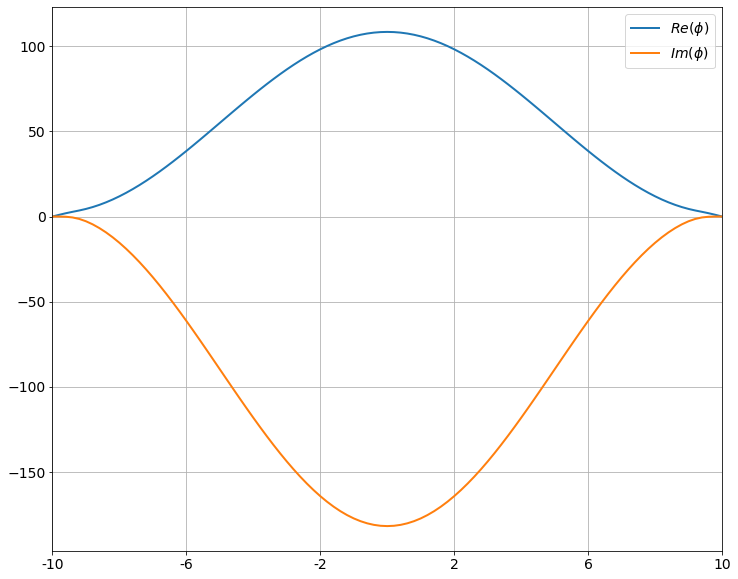

In [70]:
fig, axes=plt.subplots(figsize=(12,10))

axes.plot(PHI.real,lw=2,label=r"$Re(\phi)$")
axes.plot(PHI.imag,lw=2,label=r"$Im(\phi)$")
axes.set_xlim([0,100])
axes.set_xlabel(f'')
axes.set_xticks((0,20,40,60,80,100))
axes.set_xticklabels(('-10','-6','-2','2','6','10'))
axes.legend(loc='best')
axes.grid()

plt.show()

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


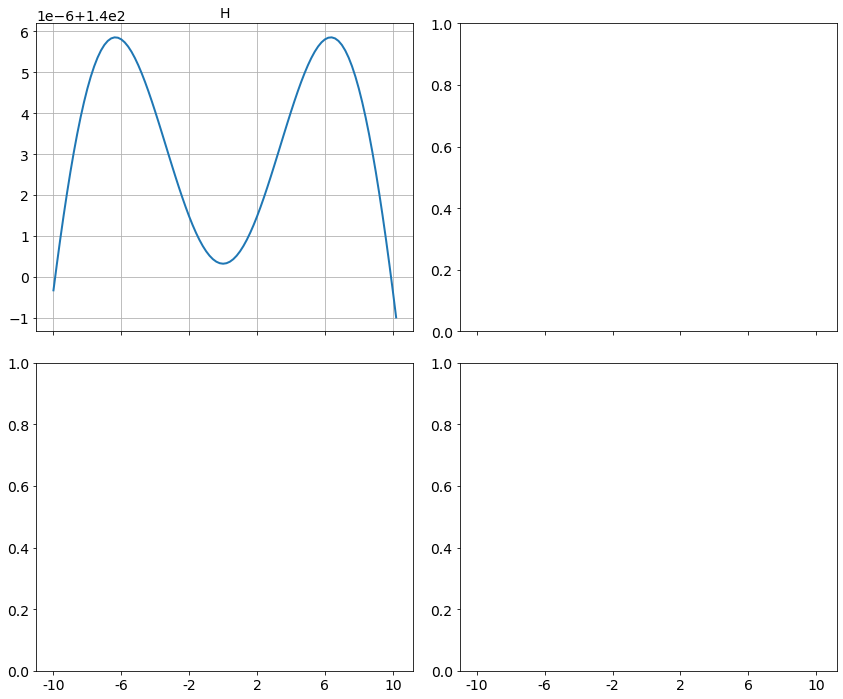

In [21]:
fig, axes=plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(12,10))


axes[0,0].plot(H0+H,linewidth=2)
axes[0,0].set_xlabel(f'')
axes[0,0].set_ylabel(f'')
axes[0,0].set_title(f'H')
axes[0,0].grid()
axes[0,0].set_xticks((0,20,40,60,80,100))
axes[0,0].set_xticklabels(('-10','-6','-2','2','6','10'))

plt.tight_layout()
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


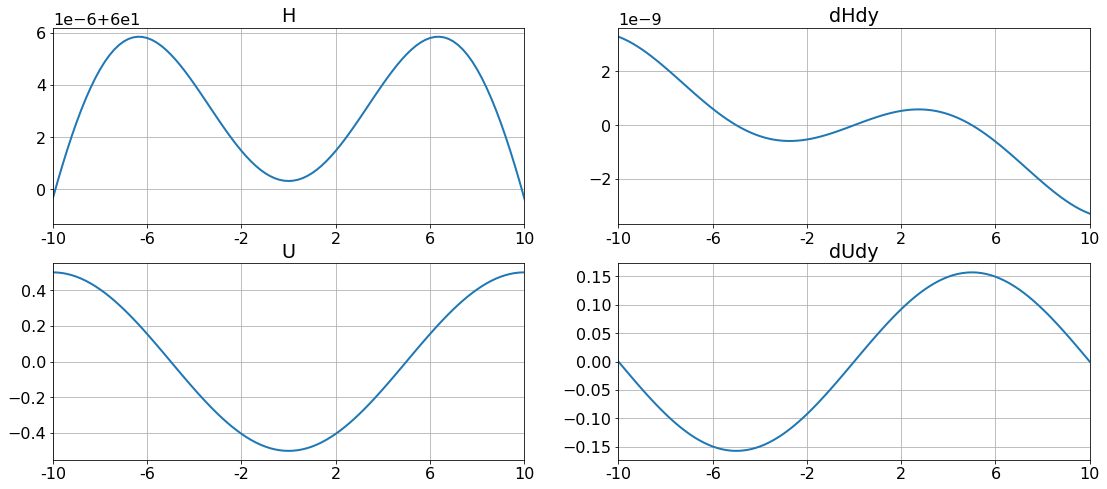

In [8]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(221)
ax1.plot(H0+H,linewidth=2)
ax1.set_xlim([0,Levels])
ax1.set_title('H')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax1.grid()
#ax1.xaxis.set_ticklabels([])

ax2 = plt.subplot(222)
ax2.plot(dHdy,linewidth=2)
ax2.set_xlim([0,Levels])
ax2.set_title('dHdy')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax2.grid()
#ax2.xaxis.set_ticklabels([])

ax3 = plt.subplot(223)
ax3.plot(U,linewidth=2)
ax3.set_xlim([0,Levels])
ax3.set_title('U')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax3.grid()
#ax3.xaxis.set_ticklabels([])

ax4 = plt.subplot(224)
ax4.plot(dUdy,linewidth=2)
ax4.set_xlim([0,Levels])
ax4.set_title('dUdy')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax4.grid()
#ax4.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)#,hspace=1)
#plt.savefig(f'H,U,dHdy,dUdy_{i}.png',dpi=300,bbox_inches='tight')

plt.show()

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


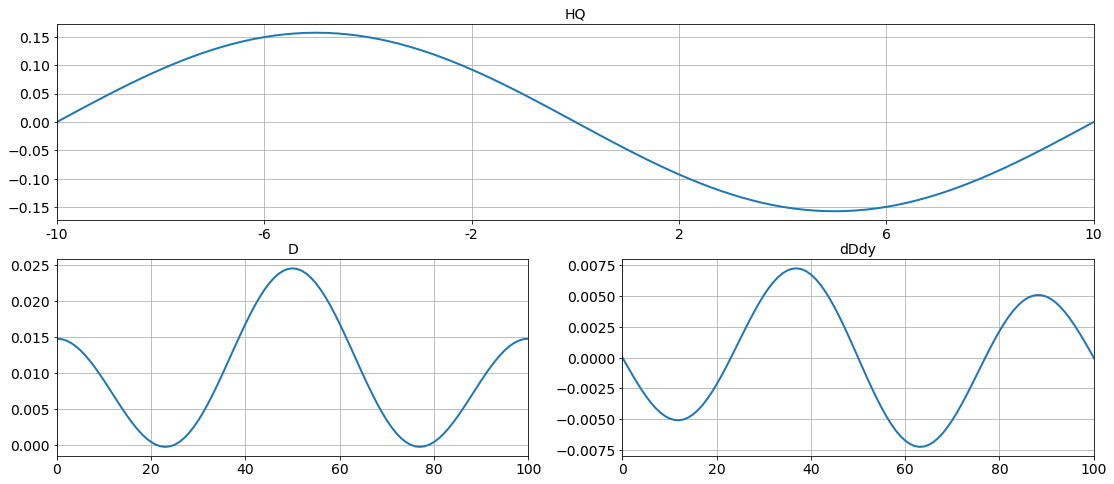

In [23]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(211)
ax1.plot(HQ,linewidth=2)
ax1.set_xlim([0,Levels])
ax1.set_title('HQ')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax1.grid()
#ax1.xaxis.set_ticklabels([])

ax2 = plt.subplot(212)
ax2.plot(dHQdy,linewidth=2)
ax2.set_xlim([0,Levels])
ax2.set_title('dHQdy')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax2.grid()
#ax2.xaxis.set_ticklabels([])

ax3 = plt.subplot(223)
ax3.plot(D,linewidth=2)
ax3.set_xlim([0,Levels])
ax3.set_title('D')
ax3.grid()
#ax3.xaxis.set_ticklabels([])

ax4 = plt.subplot(224)
ax4.plot(dDdy,linewidth=2)
ax4.set_xlim([0,Levels])
ax4.set_title('dDdy')
ax4.grid()
#ax4.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
#plt.savefig(f'HQ,dHQdy_{i}.png',dpi=300,bbox_inches='tight')

plt.show()
plt.close()

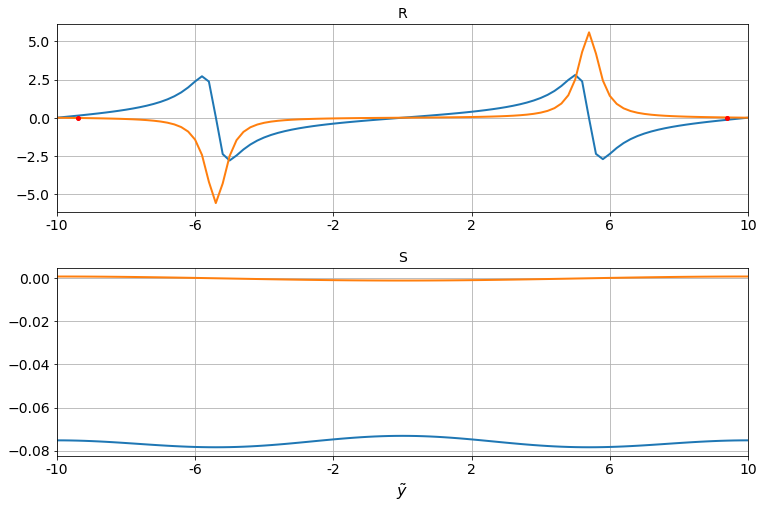

In [24]:
plt.figure(figsize=(8,6))

ax1 = plt.subplot(211)
ax1.plot(R.real,linewidth=2,label='R.real')
ax1.plot(R.imag,linewidth=2,label='R.imag')
#ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax1.set_xlim([0,Levels])
ax1.set_title('R')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax1.grid()
#plt.legend()
#ax1.xaxis.set_ticklabels([])

ax2 = plt.subplot(212)
ax2.plot(S.real,linewidth=2,label='S.real')
ax2.plot(S.imag,linewidth=2,label='S.imag')
ax2.set_xlim([0,Levels])
ax2.set_title('S')
ax2.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax2.grid()
#plt.legend()
#ax2.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.3)
#plt.savefig(f'R,S.png',dpi=300,bbox_inches='tight')

plt.show()
plt.close()

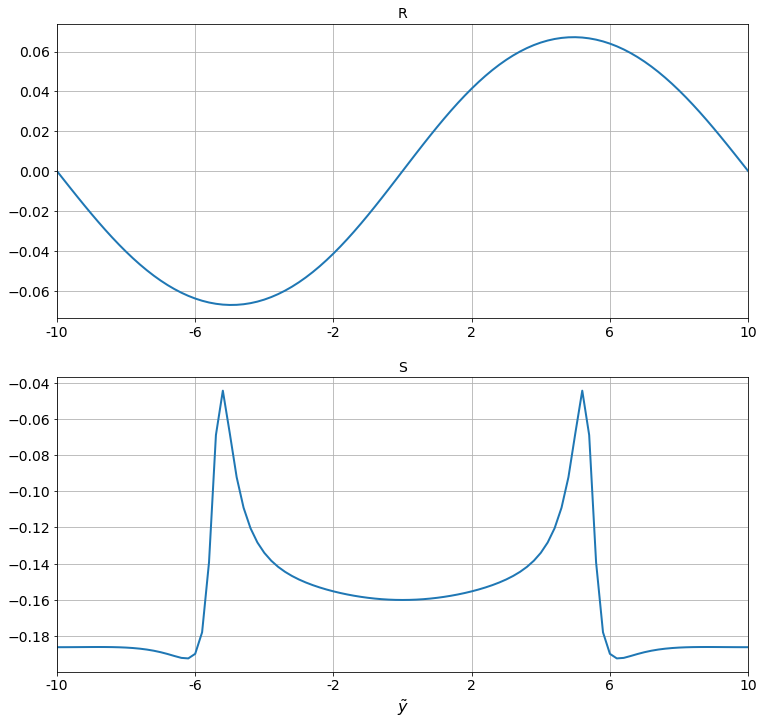

In [26]:
plt.figure(figsize=(8,6))

ax1 = plt.subplot(211)
ax1.plot(Rv.real,linewidth=2,label='Rv.real')
#ax1.plot(Rv.imag,linewidth=2,label='Rv.imag')
ax1.set_xlim([0,Levels])
ax1.set_title('R')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax1.grid()
#plt.legend()
#ax1.xaxis.set_ticklabels([])


ax2 = plt.subplot(212)
ax2.plot(Sv.real,linewidth=2,label='Sv.real')
#ax2.plot(Sv.imag,linewidth=2,label='Sv.imag')
#ax2.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax2.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax2.set_xlim([0,Levels])
ax2.set_xlabel(r"$\tilde{y}$")
ax2.set_title('S')
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
ax2.grid()
#plt.legend()
#ax2.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1)
#plt.savefig(f'Pv,Qv.png',dpi=300,bbox_inches='tight')

plt.show()
plt.close()

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


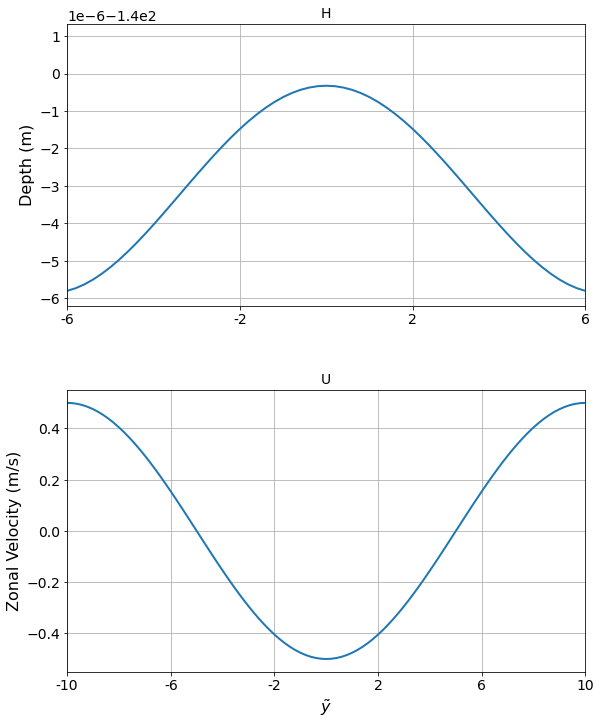

In [28]:
plt.figure(figsize=(6,6))

ax1 = plt.subplot(211)
ax1.plot(-(H0+H),linewidth=2)
ax1.set_xlim([20,Levels-20])
ax1.set_title('H')
plt.xticks((20,40,60,80),('-6','-2','2','6'))
#plt.yticks((-54.0,-56.0,-58.0,-60.0,-62.0,-64.0),(54.0,56.0,58.0,60.0,62.0,64.0))
plt.ylabel('Depth (m)')
ax1.grid()
#ax1.xaxis.set_ticklabels([])


ax2 = plt.subplot(212)
ax2.plot(U,linewidth=2)
ax2.set_xlim([20,Levels-20])
ax2.set_title('U')
ax2.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,20,40,60,80,100),('-10','-6','-2','2','6','10'))
plt.ylabel('Zonal Velocity (m/s)')
ax2.grid()
#ax2.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=-0.5, right=1.2, left = 0, top=1,hspace=0.3)
#plt.savefig(f'U_Presentation.png',dpi=300,bbox_inches='tight')

plt.show()

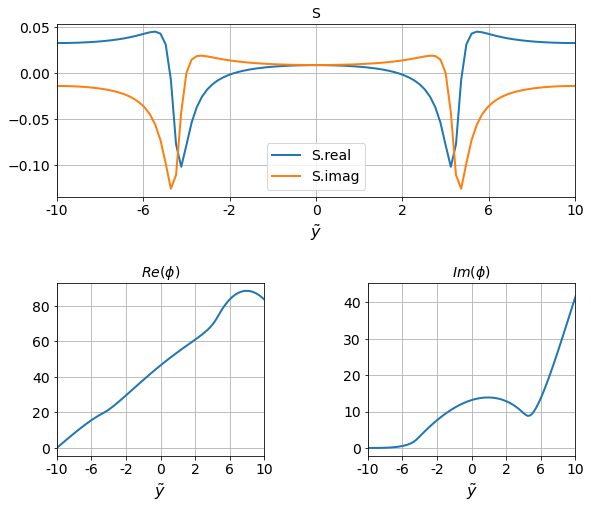

In [29]:
plt.figure(figsize=(6,6))

ax1 = plt.subplot(211)
ax1.plot(Ss.real,linewidth=2,label='S.real')
ax1.plot(Ss.imag,linewidth=2,label='S.imag')
#ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax1.set_xlim([0,Levels])
ax1.set_title(f'S')
ax1.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax1.grid()
plt.legend()
#ax1.xaxis.set_ticklabels([])

ax2 = plt.subplot(223)
ax2.plot(PHI.real,linewidth=2)
ax2.set_xlim([0,Levels])
ax2.set_title(f'$Re(\phi)$')
ax2.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax2.grid()
#ax2.xaxis.set_ticklabels([])

ax3 = plt.subplot(224)
ax3.plot(PHI.imag,linewidth=2)
ax3.set_xlim([0,Levels])
ax3.set_title(f'$Im(\phi)$')
ax3.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax3.grid()
#ax2.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title 

plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.5,wspace=0.5)
#plt.savefig(f'Ss_PHI_k=035_cr=0_ci=01.png',dpi=300,bbox_inches='tight')

plt.show()

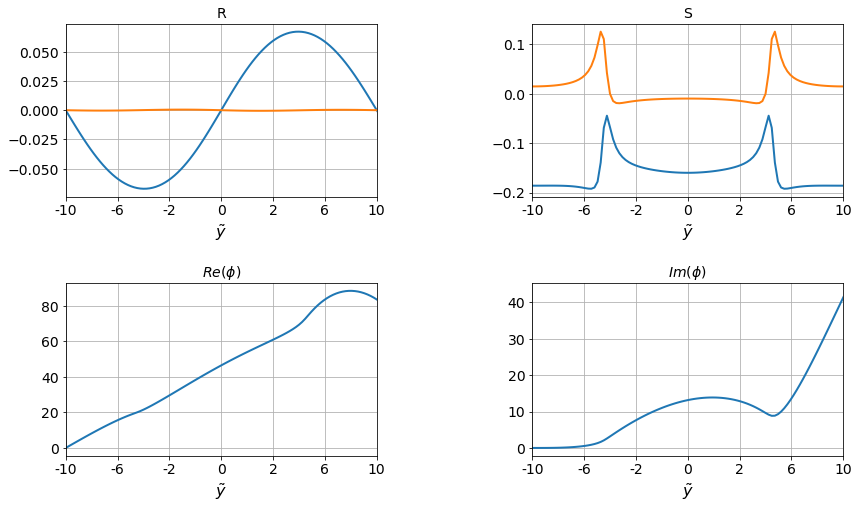

In [30]:
plt.figure(figsize=(9,6))

ax1 = plt.subplot(221)
ax1.plot(Rv.real,linewidth=2,label='R.real')
ax1.plot(Rv.imag,linewidth=2,label='R.imag')
#ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax1.set_xlim([0,Levels])
ax1.set_title(f'R')
ax1.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax1.grid()
#plt.legend()
#ax1.xaxis.set_ticklabels([])

ax2 = plt.subplot(222)
ax2.plot(Sv.real,linewidth=2,label='S.real')
ax2.plot(Sv.imag,linewidth=2,label='S.imag')
#ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax2.set_xlim([0,Levels])
ax2.set_title(f'S')
ax2.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax2.grid()
#plt.legend()
#ax1.xaxis.set_ticklabels([])

ax3 = plt.subplot(223)
ax3.plot(PHI.real,linewidth=2)
ax3.set_xlim([0,Levels])
ax3.set_title(f'$Re(\phi)$')
ax3.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax3.grid()
#ax2.xaxis.set_ticklabels([])

ax4 = plt.subplot(224)
ax4.plot(PHI.imag,linewidth=2)
ax4.set_xlim([0,Levels])
ax4.set_title(f'$Im(\phi)$')
ax4.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax4.grid()
#ax2.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.5,wspace=0.5)
#plt.savefig(f'Pv_Qv_PHI_k=SWC_cr=0_ci=001.png',dpi=300,bbox_inches='tight')

plt.show()

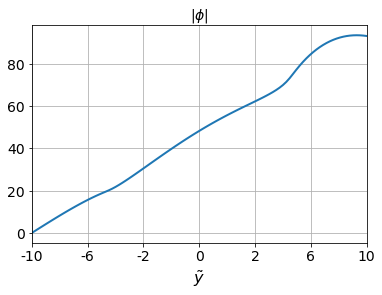

In [31]:
plt.plot(abs(PHI),linewidth=2)
plt.title(f'$|\phi|$')
plt.xlabel(r"$\tilde{y}$")
plt.xlim([0,Levels])
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
plt.grid()

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title
plt.show()

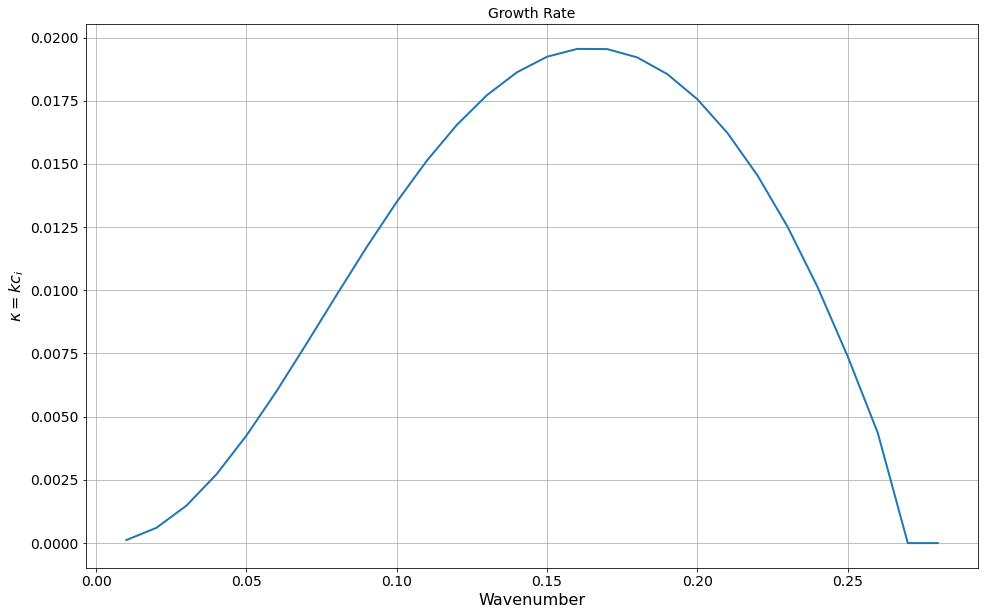

In [34]:
kappa = K*(cs.imag)             
wavenumberstep = d_k
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))
ax1 = plt.subplot(111)
ax1.plot(K,kappa,linewidth=2)  
ax1.set_title(r"Growth Rate")
ax1.set_xlabel(f'Wavenumber')
ax1.set_ylabel(r"$\kappa = kc_{i}$")
ax1.grid()
#ax1.set_xlim([0, 0.255])
#ax1.set_ylim([-0.002, 0.02])
#plt.savefig(f'R_Growth_Rate_2.png',dpi=300,bbox='tight')
#plt.savefig(f'Rs_Growth_Rate.png',dpi=300,bbox='tight')
#plt.savefig(f'Rv_Growth_Rate.png',dpi=300,bbox='tight')
plt.show()

All wavespeeds converge


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


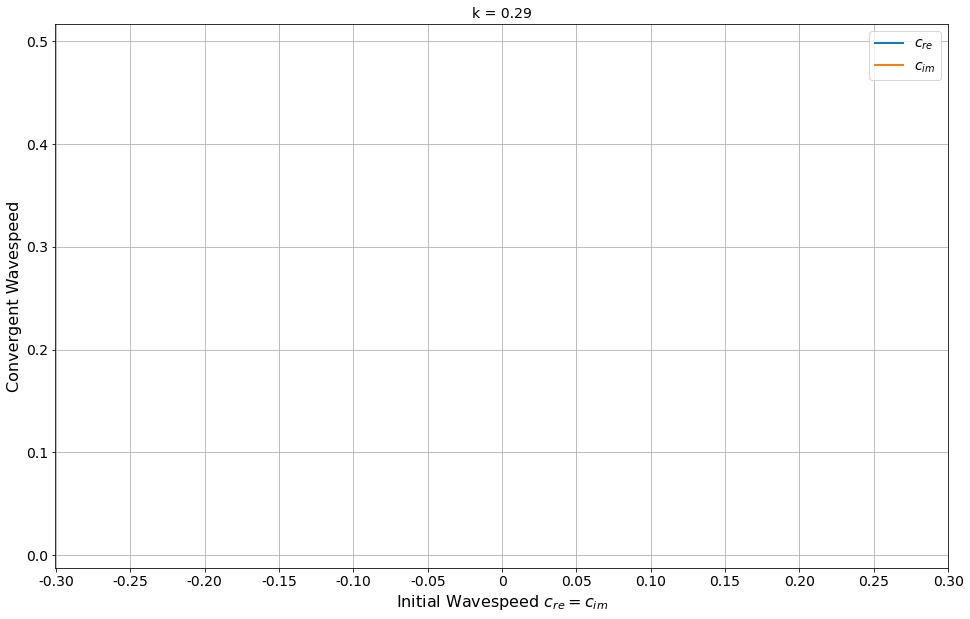

In [37]:
#Plots of multiple wavespeed guesses and their convergence
B = np.where(cs_converge.imag == 0)
A = np.zeros(len(B))
D = np.where(cs_converge.real == 0)
C = np.zeros(len(D))

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))
ax1 = plt.subplot(111)
ax1.plot(cs_converge.real,lw=2,label=r'$c_{re}$')
ax1.plot(cs_converge.imag,lw=2,label=r'$c_{im}$')

if 0 in cs_converge:
    for i in range(len(D)):
        ax1.plot(D,C,ms=14,marker='.',color='k')
    for i in range(len(B)):
        ax1.plot(B,A,ms=14,marker='.',color='k')
else:
    print(f'All wavespeeds converge')

ax1.set_title(f'k = {k:.2f}')
ax1.set_xlabel(r"Initial Wavespeed $c_{re}=c_{im}$")
ax1.set_ylabel(r"Convergent Wavespeed")
ax1.grid()
ax1.set_xlim([0,step-1])
plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60],['-0.30','-0.25','-0.20','-0.15','-0.10','-0.05','0','0.05','0.10','0.15','0.20','0.25','0.30'])
plt.legend(loc='best')
plt.show()  

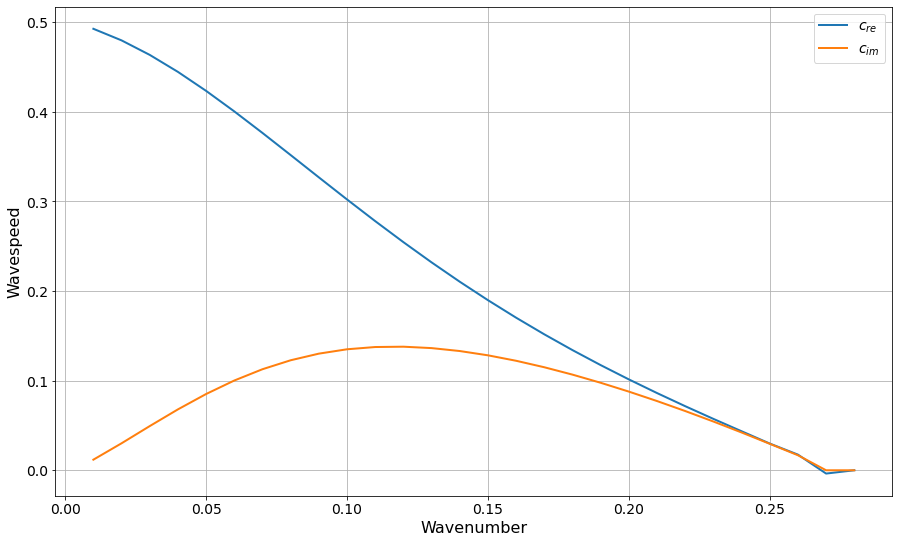

In [36]:
plt.figure(figsize=(15,9))
ax1 = plt.subplot(111)
ax1.plot(K,cs.real,lw=2,label=r'$c_{re}$')
ax1.plot(K,cs.imag,lw=2,label=r'$c_{im}$')
ax1.grid()
ax1.set_ylabel('Wavespeed')
ax1.set_xlabel('Wavenumber')
ax1.legend(loc='best')
#ax1.set_xlim([0,0.255])
plt.show()

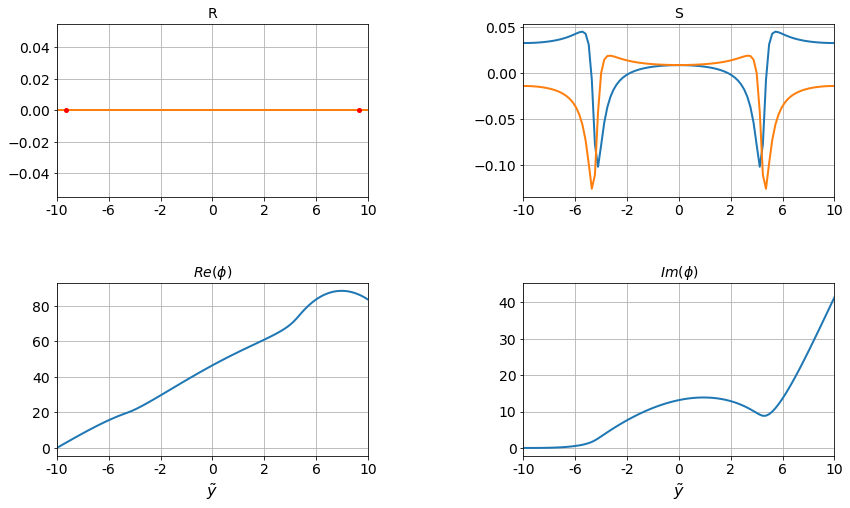

In [39]:
mod_Dopp = np.abs(U-c_0_re)                 # |U-c_{r}|
min_mod_Dopp = np.amin(mod_Dopp)            # min|U-c_{r}| (approx where U=c)
ind_min_mod_Dopp = np.argmin(mod_Dopp)      # Index where this occurs so we can plot a marker there

plt.figure(figsize=(9,6))

ax1 = plt.subplot(221)
ax1.plot(Rs.real,linewidth=2,label='R.real')
ax1.plot(Rs.imag,linewidth=2,label='R.imag')
#ax1.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax1.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax1.set_xlim([0,Levels])
ax1.set_title(f'R')
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax1.grid()
#plt.legend()
#ax1.xaxis.set_ticklabels([])

ax2 = plt.subplot(222)
ax2.plot(Ss.real,linewidth=2,label='S.real')
ax2.plot(Ss.imag,linewidth=2,label='S.imag')
#ax2.plot([ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
#ax2.plot([Levels - ind_min_mod_Dopp],[0],marker='o',markersize=4,color='red')
ax2.set_xlim([0,Levels])
ax2.set_title(f'S')
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax2.grid()
#plt.legend()
#ax1.xaxis.set_ticklabels([])

ax3 = plt.subplot(223)
ax3.plot(PHI.real,linewidth=2)
ax3.set_xlim([0,Levels])
ax3.set_title(f'$Re(\phi)$')
ax3.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax3.grid()
#ax2.xaxis.set_ticklabels([])

ax4 = plt.subplot(224)
ax4.plot(PHI.imag,linewidth=2)
ax4.set_xlim([0,Levels])
ax4.set_title(f'$Im(\phi)$')
ax4.set_xlabel(r"$\tilde{y}$")
plt.xticks((0,Levels/6.0,Levels/3.0,Levels/2.0,2*Levels/3.0,5*Levels/6.0,Levels),('-10','-6','-2','0','2','6','10'))
ax4.grid()
#ax2.xaxis.set_ticklabels([])

plt.rc('font',         size=SMALL_SIZE)    # controls default text sizes
plt.rc('axes',    titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick',   labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend',   fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the title

plt.subplots_adjust(bottom=0, right=1.2, left = 0, top=1,hspace=0.5,wspace=0.5)
#plt.savefig(f'Rv_max_growth_rate.png',dpi=300,bbox_inches='tight')


plt.show()
plt.close()